<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

In [180]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import re
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scikitplot as skplt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.colors import ListedColormap


## Import up sound alert dependencies
from IPython.display import Audio, display
from playsound import playsound

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import scikitplot as skplt
from matplotlib.colors import ListedColormap


def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn



In [181]:
def alldone():
#     display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
    playsound('/System/Library/Sounds/Purr.aiff')
    playsound('/System/Library/Sounds/Purr.aiff')
    playsound('/System/Library/Sounds/Purr.aiff')
    
alldone()


### Load in the the data of scraped salaries

In [182]:
df = pd.read_csv('./uk_jobz_salary5.csv')

In [183]:
dfe = pd.read_csv('./europa_jobz_salary.csv')

In [184]:
df_all = pd.concat([df,dfe])

In [334]:
df_all.head()


,job_title,company,rating,salary,description,date,category
0,Data Scientist - Machine Learning,Metrica Recruitment,NaN,52500.0,As a Data Scientist you will be using advance...,30+ days ago,London
1,Business Intelligence Analyst,Southern Housing,4,37500.0,The Business Intelligence Analyst role:Work w...,30+ days ago,London
2,Machine Learning Engineer (Researcher),ThirdEye Labs,NaN,52500.0,Strong understanding of deep learning and wor...,30+ days ago,London
3,Machine Learning Engineer,Migacore Technologies,NaN,47500.0,"Skills: Python, Machine Learning, D3.js, Kera...",Today,London
4,Business Intelligence Analyst,Wayhome,NaN,60000.0,And answering business questions with data an...,6 days ago,London


### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [185]:
# uk salaries
df.salary.describe()

count      1168.000000
mean      44801.844606
std       19380.753496
min       11000.000000
25%       32000.000000
50%       40000.000000
75%       55000.000000
max      152500.000000
Name: salary, dtype: float64

In [186]:
# all salaries
df_all.salary.describe()


count      1482.000000
mean      45424.583755
std       19515.237948
min       10200.000000
25%       32500.000000
50%       41000.000000
75%       55000.000000
max      152500.000000
Name: salary, dtype: float64

To make this interesting I am going to split into 4 categories, which will be based on the quartiles of the salary data:
 - Low (0) = less than 32.5k 
 - Medium (1) = between 32.5k and 41k
 - High (2) = between 41k and 55k
 - Very High (3) = above 55k

In [187]:

df_all['salary_category']=df_all.salary.map(lambda x: 0 if x < 32500 else (1 if x < 41000 else (2 if x < 55000 else 3)))

In [188]:
df_all.head()

,job_title,company,rating,salary,description,date,category,salary_category
0,Data Scientist - Machine Learning,Metrica Recruitment,NaN,52500.0,As a Data Scientist you will be using advance...,30+ days ago,London,2
1,Business Intelligence Analyst,Southern Housing,4,37500.0,The Business Intelligence Analyst role:Work w...,30+ days ago,London,1
2,Machine Learning Engineer (Researcher),ThirdEye Labs,NaN,52500.0,Strong understanding of deep learning and wor...,30+ days ago,London,2
3,Machine Learning Engineer,Migacore Technologies,NaN,47500.0,"Skills: Python, Machine Learning, D3.js, Kera...",Today,London,2
4,Business Intelligence Analyst,Wayhome,NaN,60000.0,And answering business questions with data an...,6 days ago,London,3


In [322]:
df_all["category"] = df_all.category.map(lambda x: x.replace("Newcastle+upon+Tyne",'Newcastle'))

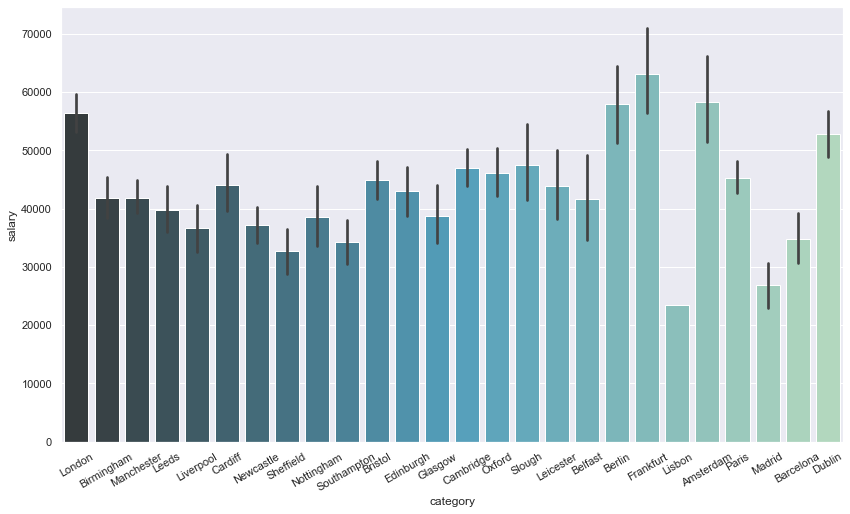

In [328]:
ax = sns.barplot(x=df_all.category,y=df_all.salary,palette='GnBu_d');
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

# df_all.groupby(["category"]).mean()

In [190]:
df_all['date'].value_counts()

30+ days ago               642
12 days ago                 51
Il y a plus de 30 jours     51
3 days ago                  49
13 days ago                 48
                          ... 
hace 16 días                 1
Recién publicado             1
il y a 20 jours              1
il y a 28 jours              1
18 dagen geleden             1
Name: date, Length: 86, dtype: int64

#### Thought experiment: What is the baseline accuracy for this model?

In [191]:
print(df_all['salary_category'].value_counts(normalize=True))

baseline= df_all['salary_category'].value_counts(normalize=True)[3]


3    0.273279
1    0.251012
0    0.248313
2    0.227395
Name: salary_category, dtype: float64


Baseline accuracy is 27.32% and will be passed into the class.

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [192]:
class full_classification:
    """A class which automatically does all classification models and gridsearches for you (logisitic default). Remember to input baseline figure and decide if you want standardisation.
    Note: when you run a new model it will overwrite the previous model. You can access the current model with .model and .model_des.
    Created by LukeBetham"""

    def __init__(self, X, y, baseline=0, standardize="none", test_size=0.15, folds=6, shuffle=True):

        # Set up the KFolds
        self.folds = folds
        self.shuffle = shuffle
        # Option for bolding print text
        self.BOLD = '\033[1m'
        self.END = '\033[0m'
        # Create train-test if selected
        self.X = X
        self.y = y
        self.baseline = baseline
        self.test = test_size
        if self.test != 0:
            self.X, self.X_test, self.y, self.y_test = train_test_split(
                self.X, self.y, test_size=self.test, random_state=66)
        # Standardise the data if selected
        if standardize != 'none':
            scaler = StandardScaler()
            self.X = pd.DataFrame(
                scaler.fit_transform(self.X), columns=X.columns)
            if self.test != 0:
                self.X_test = pd.DataFrame(
                    scaler.transform(self.X_test), columns=X.columns)
        # Call the 3 standard models
        self.knn_model(5)
        self.decision_tree_model()
        self.logistic_model()

    def logistic_model(self, Logistic=LogisticRegression(penalty='none', max_iter=1000)):
        # Set up Logistic Regresssion
        self.model = Logistic
        self.model_des = "Logistic Regression Model"
        self.model_calc()
        print("Run .coefs() to see coef dataframe\nTime Elapsed = ", round(self.elaspsed, 2),
              'secs - grid will take ~', round(self.elaspsed*30, 2), 'minutes to run.\n')

    def knn_model(self, k='all', weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None):
        if k != 'all':
            # set up KNN model
            self.model = KNeighborsClassifier(n_neighbors=k, weights=weights, algorithm=algorithm,
                                              leaf_size=leaf_size, p=p, metric=metric, metric_params=metric_params, n_jobs=n_jobs)
            self.model_des = "K Neighbors Model"
            self.model_calc()
            print("Set k='all' to run full set of ks and graph.\nTime Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~', round(
                self.elaspsed*7, 2), 'minutes to run - and all ks', round(int(len(self.y)*(1-(1/self.folds))-1)*self.elaspsed/120, 2), 'mins\n')

        else:
            # run KNN for all possible Ks and graph them
            self.scores = []
            self.max_k = int(len(self.y)*(1-(1/self.folds))-1)
            for k in range(1, self.max_k):
                knn = KNeighborsClassifier(n_neighbors=k, weights=weights, algorithm=algorithm,
                                           leaf_size=leaf_size, p=p, metric=metric, metric_params=metric_params, n_jobs=n_jobs)
                self.scores.append(np.mean(cross_val_score(knn, self.X, self.y, cv=KFold(
                    self.folds, shuffle=self.shuffle, random_state=66))))
            self.knn_best = self.scores.index(np.max(self.scores))+1
            plt.plot(range(1, self.max_k), self.scores, label='Mean CV Scores')
            plt.hlines(self.baseline, 1, self.max_k, label='baseline')
            plt.xlabel('k')
            plt.ylabel('accuracy')
            plt.legend(loc=[1.1, 0])
            print(self.BOLD + "Highest KNN Score:" + self.END, self.knn_best)
            plt.show()

    def decision_tree_model(self, print_tree="y", DecisionTree=DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, random_state=66)):
        # set up decision tree model
        self.model = DecisionTree
        self.model_des = "Decision Tree Model"
        self.model_calc()
        print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
              round(self.elaspsed*50, 2), 'minutes to run.\n')
        if print_tree == 'y':
            # insert code to view tree here
            pass
        else:
            pass

    def random_forest_model(self, forest=RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, random_state=66)):
        self.model = forest
        self.model_des = "Random Forest Model"
        self.model_calc()
        print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
              round(self.elaspsed*9.5, 2), 'minutes to run.\n')

    def boosting_model(self, plot_it=True, estimators=100, base_estimator=DecisionTreeClassifier(max_depth=3,random_state=66)):
        self.model = AdaBoostClassifier(
            base_estimator=base_estimator, n_estimators=estimators, algorithm='SAMME', random_state=66)
        self.model_des = "Boosting Model"
        self.model_calc()
        print("Time Elapsed = ", round(self.elaspsed, 2), 'secs - grid will take ~',
              round(self.elaspsed*2.5, 2), 'minutes to run.\n')
        # plot
        if plot_it == True:
            plt.plot(list(self.model.staged_score(self.X, self.y)),
                     label='training score', lw=2)
            plt.plot(list(self.model.staged_score(
                self.X_test, self.y_test)), label='test score', lw=2)
            plt.xlabel('iteration')
            plt.ylabel('score')
            plt.legend()
            plt.show()

    def coefs(self):
        self.dfc = pd.DataFrame(self.coef, columns=self.X.columns)
        return self.dfc

    def model_calc(self):
        # fit model
        t0 = time.time()
        self.model.fit(self.X, self.y)
        self.sc = self.model.score(self.X, self.y)
        self.cvs = cross_val_score(self.model, self.X, self.y, cv=KFold(
            self.folds, shuffle=self.shuffle, random_state=66)).mean()
        # Get test score
        if self.test != 0:
            self.sct = self.model.score(self.X_test, self.y_test)
            self.sctp = str(round(self.sct, 4))+" - better than baseline by " + \
                str(round(self.sct-self.baseline, 4))
        else:
            self.sctp = None
        t1 = time.time()
        self.elaspsed = t1-t0
        # show the results from the classification model
        print(self.BOLD + self.model_des, 'Test\nModel Score:' + self.END, round(self.sc, 4), "- better than baseline by", round(self.sc-self.baseline, 4),
              self.BOLD + '\nCV Fold Score:' +
              self.END, round(
                  self.cvs, 4), "- better than baseline by", round(self.cvs-self.baseline, 4),
              self.BOLD + "\nModel Test Score:" + self.END, self.sctp)
        try:
            self.coef = self.model.coef_
            self.coefs
        except:
            pass
        print("Use .gridsearch() to run full regularisation tests using all default for current model.",
              "\nUse .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.")

    def gridsearch(self, params='default'):
        """A function which automatically runs a gridsearch on your selected model. Returns model_grid model with best parameters.
        Defaults for Logistic (600 iterations): {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'C': np.logspace(-5, 5, 5), 'l1_ratio': np.linspace(0.0001, 1, 4)}
        Defaults for KNN: self.params (100 iterations) = {'n_neighbors':range(1,20,1), 'weights':['uniform','distance'], 'p':[1,2]}         
        Defaults for Decision Tree (1000 iterations) = {'criterion':['gini','entropy'],'max_depth': [None,5,6,7,8],'max_features':['auto'],'splitter':['best','random'],'min_samples_split':[2,3,4,5],'ccp_alpha':[0.0,0.0001,0.001,.01,.1,1,10,100],'class_weight':[None,'balanced']}        
        Defaults for Random Forest (575 iterations) = {'n_estimators':[100,200,500], 'criterion':['gini':'entropy'], 'max_depth':[None], 'min_samples_split':[2,4,6],"max_features":["auto","log2"],'oob_score':[True,False],'warm_start':[True,False],'ccp_alpha'=[0.0,0.5,1,10]}      
        Defaults for Boosting Model  (150 iterations)  = {"learning_rate": [0.05, 0.25, 0.5, 0.75, 1], "max_depth":[1,2,3,4,5],"max_features":["auto","log2"],"n_estimators":[100,200,500]}      
                """
        # setting the default parameters if not set by user
        if params == 'default':
            if self.model_des == "Logistic Regression Model":
                self.params = {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'C': np.logspace(-5, 5, 5), 'l1_ratio': np.linspace(0.0001, 1, 4)}
            elif self.model_des == "K Neighbors Model":
                self.params = {'n_neighbors': range(1, 20, 1), 'weights': ['uniform', 'distance'], 'p': [1, 2]}
            elif self.model_des == "Decision Tree Model":
                self.params = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 6, 7, 8], 'max_features': ['auto'], 'splitter': [
                    'best', 'random'], 'min_samples_split': [2, 3, 4, 5], 'ccp_alpha': [0.0, 0.0001, 0.001, .01, .1, 1, 10, 100], 'class_weight': [None, 'balanced']}
            elif self.model_des == "Random Forest Model":
                self.params = {'n_estimators':[100,200,500], 'criterion':['gini','entropy'], 'max_depth':[None], 'min_samples_split':[2,6],"max_features":["auto","log2"],
                               'oob_score':[True,False],'warm_start':[True,False],'ccp_alpha':[0.0,0.5,1]}
            elif self.model_des == "Boosting Model": 
                self.params = {"learning_rate": [0.05, 0.25, 0.5, 0.75, 1], 'base_estimator':[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)],
                               'algorithm':['SAMME'],"n_estimators":[100,200,500,1000]}
        else:
            self.params = params

        # setup the gridsearch
        self.grid = GridSearchCV(self.model, self.params, verbose=1, cv=KFold(
            self.folds, shuffle=self.shuffle, random_state=66))
        self.grid.fit(self.X, self.y)
        self.gsc = self.grid.best_score_
        self.best = self.grid.best_params_
        self.model = self.grid.best_estimator_
        self.model_des = self.model_des + " Grid Search:"
        try:
            self.coef = self.grid.best_estimator_.coef_
        except:
            pass
        # Check test score for grid
        try:
            self.sct = self.grid.best_estimator_.score(
                self.X_test, self.y_test)
            self.sctp = str(round(self.sct, 4))+" - better than baseline by " + \
                str(round(self.sct-self.baseline, 4))
        except:
            self.sctp = None
        # Print Grid results
        print(self.BOLD + self.model_des + self.END)
        print(self.BOLD + "Best Mean CV Model Score:" + self.END, round(self.gsc, 4), "- which is better than baseline by",
              round(self.gsc-self.baseline, 4), self.BOLD + "\nModel Test Score:" + self.END, self.sctp)
        print(self.BOLD + 'Grid Best Parameters:\n' + self.END, self.best)
        print(self.BOLD + '\nSearch Parameters:\n' + self.END, self.params)
        self.coefs()

    def matrix_n_graphs(self):
        print(self.BOLD + self.model_des, "on X_test" + self.END)
        self.y_pred = self.model.predict(self.X_test)
        skplt.metrics.plot_confusion_matrix(
            self.y_test, self.y_pred, figsize=(8, 8), labels=[0, 1, 2, 3], normalize=True)
        plt.ylim([-0.5, len(self.y.unique())-0.5])
        plt.show()
        cmap = ListedColormap(sns.color_palette("husl", 3))
        skplt.metrics.plot_roc(self.y_test, self.model.predict_proba(self.X_test), plot_micro=False,
                               plot_macro=False, title_fontsize=20, text_fontsize=16, figsize=(8, 8), cmap=cmap)
        plt.show()
        fig, ax = plt.subplots(figsize=(8, 8))
        skplt.metrics.plot_precision_recall(self.y_test, self.model.predict_proba(
            self.X_test), plot_micro=False, title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
        ax.legend(loc=[1.1, 0])
        plt.show()

#### Using only location as a predictor to start: ###

In [193]:
y = df_all.pop("salary_category")

In [304]:
X = df_all.category
X.value_counts()

London                 231
Manchester             145
Dublin                  97
Oxford                  96
Birmingham              92
Cambridge               87
Leeds                   76
Bristol                 75
Paris                   75
Southampton             60
Edinburgh               47
Madrid                  39
Slough                  36
Liverpool               36
Amsterdam               35
Newcastle+upon+Tyne     35
Nottingham              34
Barcelona               27
Cardiff                 27
Leicester               25
Belfast                 24
Glasgow                 23
Frankfurt               22
Sheffield               19
Berlin                  18
Lisbon                   1
Name: category, dtype: int64

In [195]:

X = pd.get_dummies(X,drop_first=True)

In [196]:
X

,Barcelona,Belfast,Berlin,Birmingham,Bristol,Cambridge,Cardiff,Dublin,Edinburgh,Frankfurt,...,London,Madrid,Manchester,Newcastle+upon+Tyne,Nottingham,Oxford,Paris,Sheffield,Slough,Southampton
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
310,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
311,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
312,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [197]:
location_model = full_classification(X,y,baseline)


K Neighbors Model Test
Model Score: 0.3757 - better than baseline by 0.1024 
CV Fold Score: 0.3352 - better than baseline by 0.0619 
Model Test Score: 0.3543 - better than baseline by 0.081
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Set k='all' to run full set of ks and graph.
Time Elapsed =  0.27 secs - grid will take ~ 1.89 minutes to run - and all ks 2.36 mins

Decision Tree Model Test
Model Score: 0.4154 - better than baseline by 0.1421 
CV Fold Score: 0.386 - better than baseline by 0.1128 
Model Test Score: 0.3453 - better than baseline by 0.072
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  0.03 secs - grid will take ~ 1.64 minutes to run.

Logistic Regression Model Test
Mod

In [198]:
# compared to Amsterdam
location_model.coefs()

,Barcelona,Belfast,Berlin,Birmingham,Bristol,Cambridge,Cardiff,Dublin,Edinburgh,Frankfurt,...,London,Madrid,Manchester,Newcastle+upon+Tyne,Nottingham,Oxford,Paris,Sheffield,Slough,Southampton
0,1.839449,1.352754,0.068966,1.174522,0.771129,0.413694,0.351892,0.551181,1.070929,-3.778383,...,0.710957,2.667793,1.217885,1.105107,1.210513,0.534492,-0.409263,1.767473,1.326696,1.663531
1,0.463551,0.670267,-0.612913,0.258370,0.088608,0.511402,1.055819,0.035707,0.293061,-4.107102,...,-0.268927,0.753361,0.342826,1.184492,0.846680,0.783564,1.028449,1.373047,-0.272031,0.015996
2,-0.346892,-1.525675,0.080407,-0.258293,0.179443,-0.027688,-0.042562,-0.449454,-0.335467,3.851606,...,-0.103977,-0.904759,-0.263290,-0.136941,-0.570131,-0.227852,0.495162,-1.111138,-0.271960,0.095978
3,-1.956108,-0.497346,0.463540,-1.174600,-1.039180,-0.897407,-1.365149,-0.137434,-1.028523,4.033879,...,-0.338053,-2.516395,-1.297421,-2.152658,-1.487062,-1.090204,-1.114348,-2.029381,-0.782705,-1.775506


In [199]:
location_model.gridsearch()

Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Logistic Regression Model Grid Search:
Best Mean CV Model Score: 0.3844 - which is better than baseline by 0.1112 
Model Test Score: 0.3453 - better than baseline by 0.072
Grid Best Parameters:
 {'C': 1.0, 'l1_ratio': 0.0001, 'penalty': 'l2', 'solver': 'saga'}

Search Parameters:
 {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'C': array([1.00000000e-05, 3.16227766e-03, 1.00000000e+00, 3.16227766e+02,
       1.00000000e+05]), 'l1_ratio': array([1.000e-04, 3.334e-01, 6.667e-01, 1.000e+00])}


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.5min finished


In [200]:
location_model.coefs()

,Barcelona,Belfast,Berlin,Birmingham,Bristol,Cambridge,Cardiff,Dublin,Edinburgh,Frankfurt,...,London,Madrid,Manchester,Newcastle+upon+Tyne,Nottingham,Oxford,Paris,Sheffield,Slough,Southampton
0,0.842200,0.331240,-0.539203,0.308301,-0.077631,-0.406565,-0.409738,-0.284888,0.199866,-0.960605,...,-0.140713,1.516830,0.355118,0.150431,0.293964,-0.299312,-1.032191,0.597493,0.417776,0.745252
1,0.134618,0.276369,-0.578504,0.021961,-0.137922,0.261849,0.722076,-0.193150,0.053047,-0.992445,...,-0.487869,0.249303,0.104007,0.813993,0.535526,0.528831,0.699475,0.817773,-0.420596,-0.221009
2,-0.122887,-0.790683,0.118277,0.006453,0.425048,0.223505,0.159020,-0.178302,-0.062056,0.593186,...,0.155680,-0.607170,0.001392,0.041484,-0.266730,0.032062,0.664331,-0.593185,-0.017247,0.308207
3,-0.853931,0.183075,0.999431,-0.336715,-0.209495,-0.078788,-0.471358,0.656341,-0.190857,1.359864,...,0.472903,-1.158963,-0.460516,-1.005907,-0.562760,-0.261582,-0.331616,-0.822081,0.020066,-0.832451


Logistic Regression Model Grid Search: on X_test


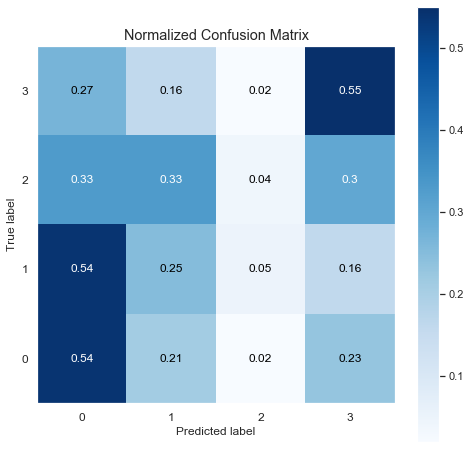

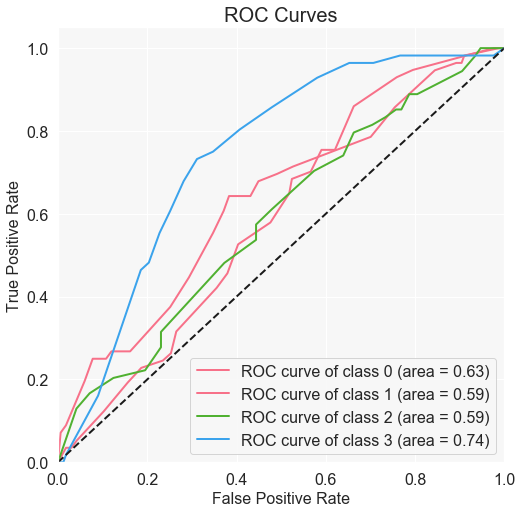

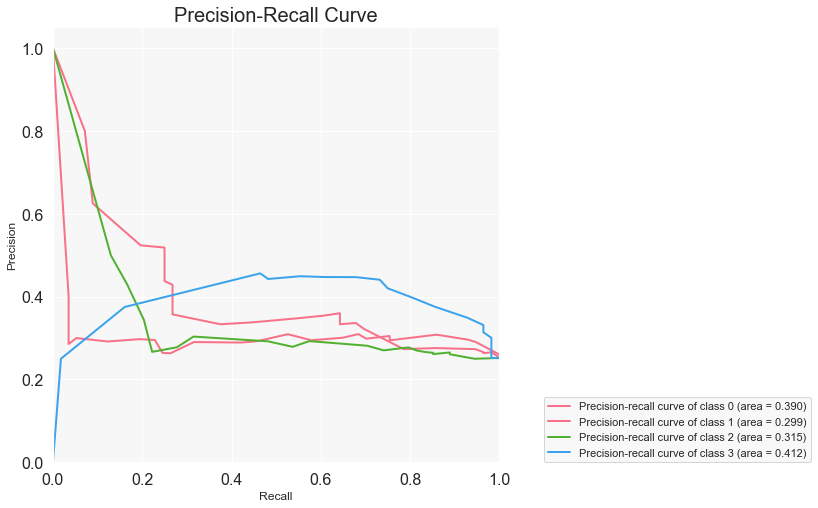

In [201]:
location_model.matrix_n_graphs()

In [202]:
alldone()

Highest KNN Score: 25


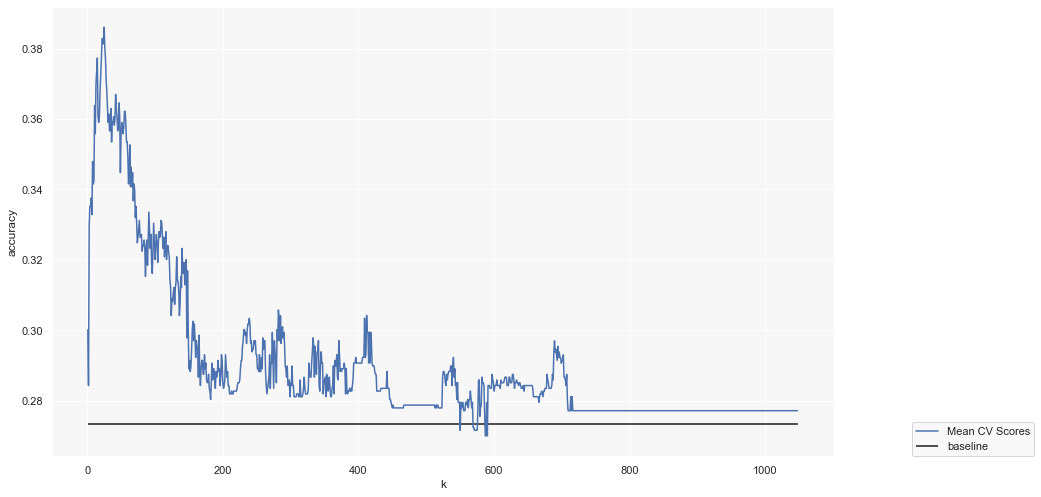

In [203]:
location_model.knn_model()

In [205]:
location_model.knn_model(25)

K Neighbors Model Test
Model Score: 0.3995 - better than baseline by 0.1262 
CV Fold Score: 0.3861 - better than baseline by 0.1128 
Model Test Score: 0.3632 - better than baseline by 0.0899
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Set k='all' to run full set of ks and graph.
Time Elapsed =  0.25 secs - grid will take ~ 1.76 minutes to run - and all ks 2.19 mins



In [207]:
location_model.gridsearch(params = {'n_neighbors': range(1, 30), 'weights': ['uniform', 'distance'], 'p': [1, 2]})

Fitting 6 folds for each of 116 candidates, totalling 696 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


K Neighbors Model Grid Search: Grid Search:
Best Mean CV Model Score: 0.3861 - which is better than baseline by 0.1128 
Model Test Score: 0.3632 - better than baseline by 0.0899
Grid Best Parameters:
 {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}

Search Parameters:
 {'n_neighbors': range(1, 30), 'weights': ['uniform', 'distance'], 'p': [1, 2]}


[Parallel(n_jobs=1)]: Done 696 out of 696 | elapsed:    9.7s finished


### Using only location, we cannot improve much from baseline. Am going to look at creating some features in order to improve the score. 

First I am going to look at using the company rating to see if this has any predictive power.

In [208]:
df_all.rating

0      NaN
1        4
2      NaN
3      NaN
4      NaN
      ... 
309    NaN
310    5.0
311    NaN
312    NaN
313    3.3
Name: rating, Length: 1482, dtype: object

In [209]:
# X['rating'].unique()

In [210]:
# splitting the ratings into quartile categories for use by the classifier - and filling na with none category
X['rating'] = df_all.rating

X['rating'].fillna("None",inplace=True)

X['rating'] = X.rating.map(lambda x: 'None' if x == 'None' else (float(x.replace(',' ,'')) if isinstance(x, str) else x))

X['rating'] = X.rating.map(lambda x: 'None' if x == 'None' else ('Low' if x < 3.5 else 
                                                                  ("Mid" if x < 4 else 
                                                                   ("High" if x < 4.3 else "Very High"))))

In [211]:
X.rating.value_counts()

None         798
Very High    293
Low          158
Mid          153
High          80
Name: rating, dtype: int64

In [212]:
X_rate = pd.get_dummies(X,drop_first=True)

In [213]:
rating_model = full_classification(X_rate,y,baseline)

K Neighbors Model Test
Model Score: 0.421 - better than baseline by 0.1477 
CV Fold Score: 0.3479 - better than baseline by 0.0746 
Model Test Score: 0.3946 - better than baseline by 0.1213
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Set k='all' to run full set of ks and graph.
Time Elapsed =  0.2 secs - grid will take ~ 1.38 minutes to run - and all ks 1.73 mins

Decision Tree Model Test
Model Score: 0.4766 - better than baseline by 0.2033 
CV Fold Score: 0.4027 - better than baseline by 0.1294 
Model Test Score: 0.4215 - better than baseline by 0.1482
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  0.03 secs - grid will take ~ 1.61 minutes to run.

Logistic Regression Model Test
Mo

### Rating has a very minimal impact on improving the model

I am going to add keywords from the job titles now

In [214]:
X_keys = X_rate.copy()


In [215]:
X_keys

,Barcelona,Belfast,Berlin,Birmingham,Bristol,Cambridge,Cardiff,Dublin,Edinburgh,Frankfurt,...,Nottingham,Oxford,Paris,Sheffield,Slough,Southampton,rating_Low,rating_Mid,rating_None,rating_Very High
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
310,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
311,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
312,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [216]:
# adding in keywords from the job title:

X_keys['salary'] = df_all.salary.reset_index(drop=True)

keywords = ['intern', 'manager', 'lead', 'analyst', 'senior', 'engineer', 'architect', 'head', 'assistant', 'junior',
            'scientist', 'machine learning', 'grad', 'intelligence','product','business','support','associate']
key_dict = {}

for key in keywords:
    key_list = []
    X_keys[key] = df_all['job_title'].reset_index(drop=True).str.contains(key,case=False)
    X_keys[key] = X_keys[key].replace(False,0).replace(True,1).astype(int)
    key_list.append(round(X_keys[key].value_counts(normalize=True)[1]*100,2))
    key_list.append(round(X_keys['salary'][X_keys[key]==1].mean()))
    key_dict[key] = key_list

X_keys.drop("salary",axis=1,inplace=True)

df_keys_salaries = pd.DataFrame(key_dict,index=["%ofentries","mean_salary"]).T
df_keys_salaries.sort_values("mean_salary",inplace=True)

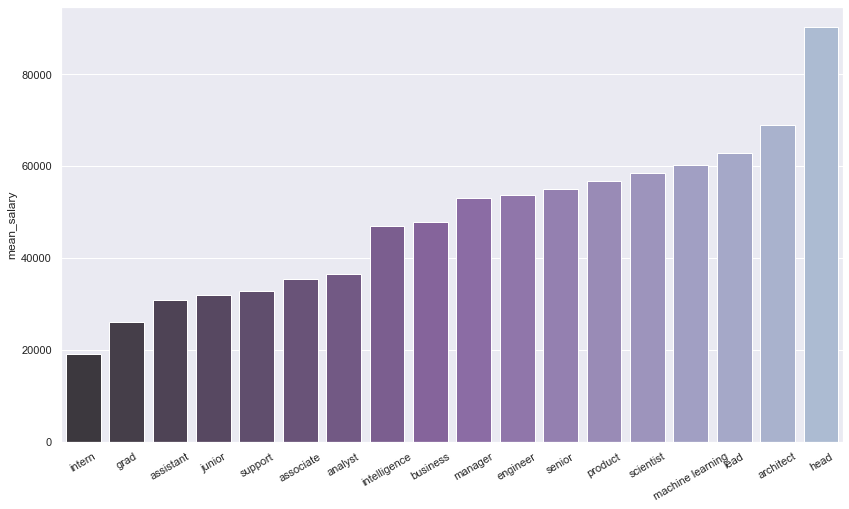

In [344]:
# graph of the mean salary per keyword
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.barplot(x=df_keys_salaries.index,y=df_keys_salaries.mean_salary,palette="BuPu_d");
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

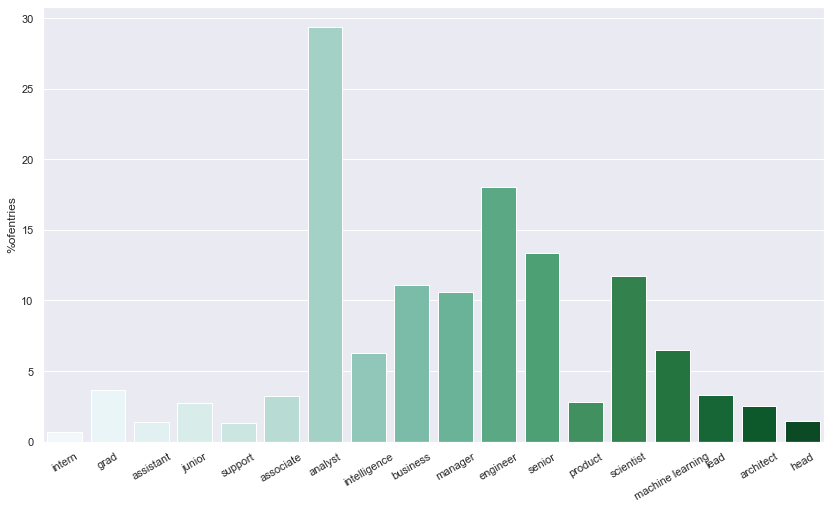

In [333]:
# graph of the frequency of keywords in % in the dataset
sns.set(rc={'figure.figsize':(14,8)})
ax = sns.barplot(x=df_keys_salaries.index,y=df_keys_salaries['%ofentries'],palette='BuGn');
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

In [219]:
# saving down this data as might want to use in tableau later on

# df_keys_salaries.to_csv('./keyword_salaries.csv')



In [220]:
# model with the key words in
key_model = full_classification(X_keys,y,baseline)

K Neighbors Model Test
Model Score: 0.6076 - better than baseline by 0.3343 
CV Fold Score: 0.4345 - better than baseline by 0.1612 
Model Test Score: 0.4305 - better than baseline by 0.1572
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Set k='all' to run full set of ks and graph.
Time Elapsed =  0.3 secs - grid will take ~ 2.08 minutes to run - and all ks 2.59 mins

Decision Tree Model Test
Model Score: 0.7927 - better than baseline by 0.5194 
CV Fold Score: 0.4417 - better than baseline by 0.1684 
Model Test Score: 0.4036 - better than baseline by 0.1303
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  0.05 secs - grid will take ~ 2.48 minutes to run.

Logistic Regression Model Test
M

In [272]:
key_model.coefs()

,Barcelona,Belfast,Berlin,Birmingham,Bristol,Cambridge,Cardiff,Dublin,Edinburgh,Frankfurt,...,assistant,junior,scientist,machine learning,grad,intelligence,product,business,support,associate
0,2.884356,2.086093,0.187992,1.583269,1.367785,0.915554,0.800340,0.732593,1.407312,-5.049251,...,5.407635,1.072285,-0.050332,-0.152331,2.214873,0.256942,-1.170911,-0.584004,1.292679,0.077240
1,0.908169,0.972456,-0.360024,0.191260,0.211502,0.675494,1.141671,-0.061522,0.444734,-4.557313,...,3.886016,0.108707,-0.416861,-0.485893,0.138122,0.750936,0.145382,-0.169984,0.414130,1.627132
2,-0.601898,-1.924340,0.204932,-0.430601,-0.040260,-0.190882,-0.182327,-0.546406,-0.326475,4.627243,...,-5.138155,0.183832,-0.292168,0.113341,-1.418946,-0.071130,0.462003,0.204610,-0.862821,-0.297369
3,-3.190626,-1.134209,-0.032900,-1.343928,-1.539028,-1.400166,-1.759685,-0.124664,-1.525570,4.979320,...,-4.155497,-1.364824,0.759361,0.524883,-0.934048,-0.936748,0.563527,0.549377,-0.843989,-1.407003


In [273]:
key_model.gridsearch()
    

Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Logistic Regression Model Grid Search:
Best Mean CV Model Score: 0.4988 - which is better than baseline by 0.2255 
Model Test Score: 0.4215 - better than baseline by 0.1482
Grid Best Parameters:
 {'C': 1.0, 'l1_ratio': 0.6667, 'penalty': 'elasticnet', 'solver': 'saga'}

Search Parameters:
 {'penalty': ['l1', 'l2', 'elasticnet'], 'solver': ['saga'], 'C': array([1.00000000e-05, 3.16227766e-03, 1.00000000e+00, 3.16227766e+02,
       1.00000000e+05]), 'l1_ratio': array([1.000e-04, 3.334e-01, 6.667e-01, 1.000e+00])}


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.1min finished


In [274]:
key_model.coefs()

,Barcelona,Belfast,Berlin,Birmingham,Bristol,Cambridge,Cardiff,Dublin,Edinburgh,Frankfurt,...,assistant,junior,scientist,machine learning,grad,intelligence,product,business,support,associate
0,1.085537,0.078012,-0.476696,0.110901,0.000000,-0.394780,-0.447978,-0.334687,0.000000,-1.367906,...,1.586526,0.678474,0.000000,0.000000,1.984131,0.000000,-0.903243,-0.468153,0.807790,0.000000
1,0.160733,0.091424,-0.339582,-0.162423,-0.042073,0.241814,0.575777,-0.165011,0.000000,-1.157546,...,0.091129,0.000000,-0.292957,-0.430820,0.000000,0.524015,0.000000,-0.059931,0.078169,1.579013
2,-0.101028,-1.075199,0.000000,0.000000,0.455093,0.161104,0.057498,0.000000,0.000000,0.632329,...,-1.112012,0.054460,-0.103578,0.000000,-0.844132,0.000000,0.269237,0.120698,-0.465845,-0.067546
3,-1.144309,0.000000,0.898630,0.000000,0.000000,-0.009347,-0.181331,1.326892,-0.083495,1.893493,...,-0.553878,-0.961688,0.792186,0.438949,-0.456662,-0.767953,0.497365,0.405092,-0.416926,-0.699189


In [275]:
alldone()

### Coeffecients

This is a good place to look a the coeffecients of the model as it is still not very crowded and I have done a best model gridsearch on a logisitical model (which has coefficients). The model is already decent, with an accuracy almost 25% above baseline. What is more - the coefficients seem to be as you would expect. They are in line with the countries and keywords which have the highest mean salaries. 

For example Frankfurt has the highest mean salaries of any of the cities, and the coefs reflect this. At class zero, coef= -1.36, at class 1 its -1.15, at 2 its 0.63 and finally at class 3 its 1.89. This indicates that the model is much more likely to predict a higher salary if the city is frankfurt. The inverse is true for the keyword junior in the job title, which makes intuitive sense. It should be noted though that since the locations have been binarised, the coeffiecients are all versus the variable which has been dropped, which is Amsterdam. Therefore, when a location has a high coefficient in the higher classes, it means that it is more likely to have a high salary - compared to Amsterdam. This is not the case in the Key words, as they are just an indicator if that word is present or not. The values are binary, but not versus a dropped variable.  

This is useful to be able to visualise how important certain features are. 


In [300]:
# key_model.coefs().to_csv('./coefs.csv')

Highest KNN Score: 21


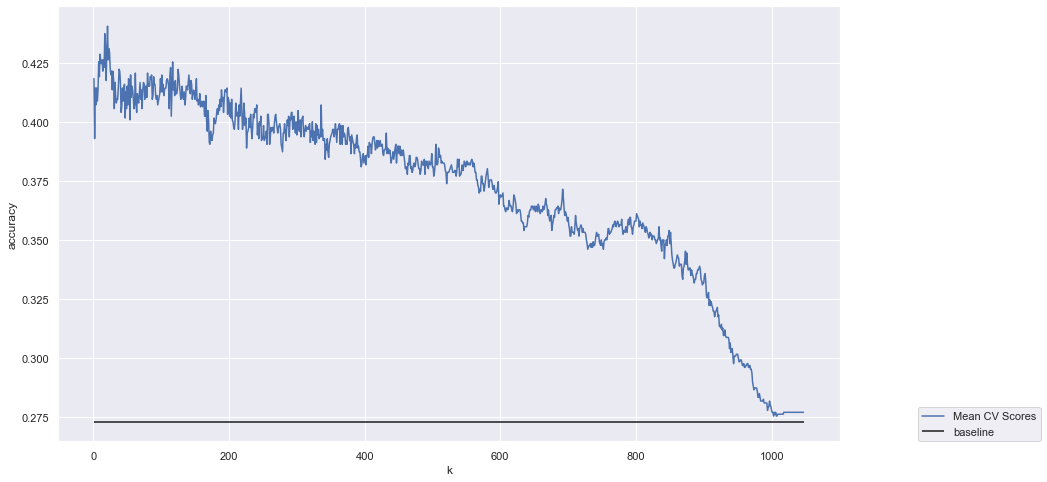

In [131]:

key_model.knn_model()

In [140]:
key_model.knn_model(21)

K Neighbors Model Test
Model Score: 0.5131 - better than baseline by 0.2398 
CV Fold Score: 0.4408 - better than baseline by 0.1675 
Model Test Score: 0.4215 - better than baseline by 0.1482
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Set k='all' to run full set of ks and graph.
Time Elapsed =  0.32 secs - grid will take ~ 2.25 minutes to run - and all ks 2.81 mins



In [ ]:
key_model.gridsearch()

Adding in the keywords definitely helps improve accuracy and stability of the model, however I am going to see if there is even further impact from adding all words from the title and descriptions as I might be missing some important keywords.

In [239]:
# count vectorizer and remodel on all words in title to see if improves
cvec = CountVectorizer(stop_words="english", ngram_range=(1,1),min_df=0.005)

# making sure I only fit on the training data - splitting the same way as rest of model
jt_train, jt_test, jt_y, jt_y_test = train_test_split(df_all['job_title'], y, test_size=0.15, random_state=66)
cvec.fit(jt_train)
# transforming the entire column
X_words = cvec.transform(df_all.job_title)

In [240]:
# # checking if TFIDF works better
# from sklearn.feature_extraction.text import TfidfVectorizer

# tvec = TfidfVectorizer(stop_words='english',ngram_range=(1, 3),min_df=0.005)
# tvec.fit(df_all.job_title)
# X_words = tvec.transform(df_all.job_title)

In [241]:
words_df = pd.DataFrame(X_words.toarray(),columns=cvec.get_feature_names())

In [242]:
word_dic = {word: [words_df[word].mean()] for word in words_df} 
word_sum = {word: [words_df[word].sum()] for word in words_df}

title_df = pd.DataFrame(word_dic).T.sort_values(0, ascending=False)
title_df_sum = pd.DataFrame(word_sum).T.sort_values(0, ascending=False)

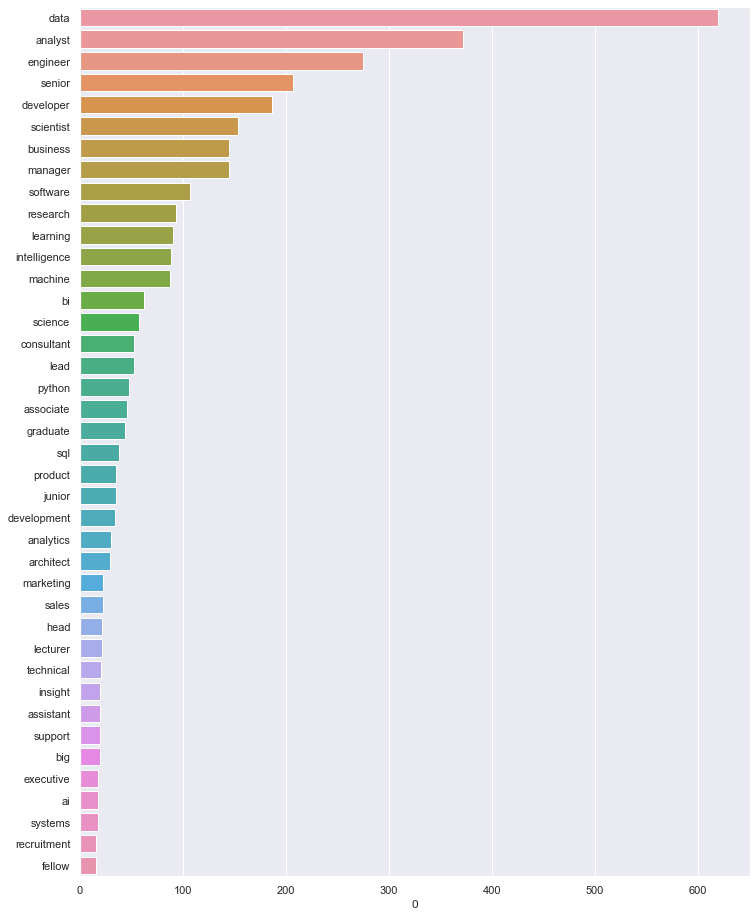

In [243]:
# Top 40 words by count
sns.set(rc={'figure.figsize':(12,16)})
sns.barplot(x=title_df_sum[0][:40],y=title_df_sum.index[:40]);

In [244]:
words_df

,account,ai,analysis,analyst,analytics,architect,artificial,assistant,associate,bi,...,studentship,support,systems,team,technical,term,test,vision,warehouse,web
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [245]:
X_rate.reset_index(drop=True,inplace=True)

In [246]:
all_title = pd.concat([X_rate,words_df],axis=1)

In [247]:
all_title_model = full_classification(all_title,y,baseline,standardize=True)

K Neighbors Model Test
Model Score: 0.6029 - better than baseline by 0.3296 
CV Fold Score: 0.4583 - better than baseline by 0.185 
Model Test Score: 0.4574 - better than baseline by 0.1841
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Set k='all' to run full set of ks and graph.
Time Elapsed =  0.59 secs - grid will take ~ 4.13 minutes to run - and all ks 5.15 mins

Decision Tree Model Test
Model Score: 0.9341 - better than baseline by 0.6608 
CV Fold Score: 0.4837 - better than baseline by 0.2105 
Model Test Score: 0.5247 - better than baseline by 0.2514
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  0.09 secs - grid will take ~ 4.33 minutes to run.

Logistic Regression Model Test
M

In [248]:
all_title_model.random_forest_model()

Random Forest Model Test
Model Score: 0.9341 - better than baseline by 0.6608 
CV Fold Score: 0.537 - better than baseline by 0.2637 
Model Test Score: 0.5516 - better than baseline by 0.2783
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  1.99 secs - grid will take ~ 18.92 minutes to run.



Boosting Model Test
Model Score: 0.7188 - better than baseline by 0.4455 
CV Fold Score: 0.5234 - better than baseline by 0.2502 
Model Test Score: 0.5471 - better than baseline by 0.2738
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  13.22 secs - grid will take ~ 33.04 minutes to run.



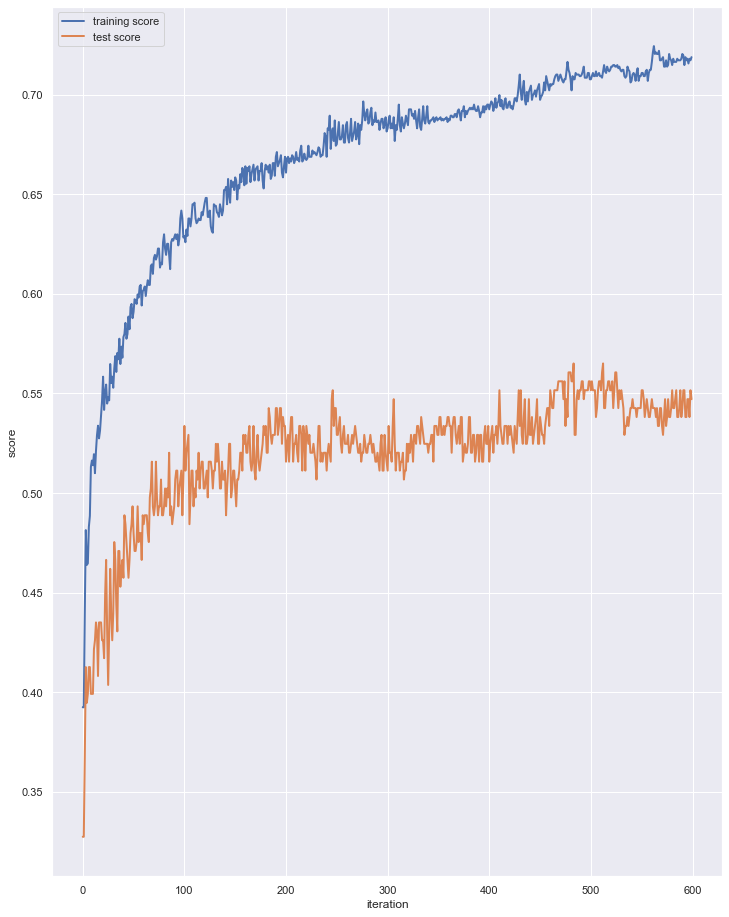

In [249]:
all_title_model.boosting_model(estimators=600)

Boosting Model on X_test


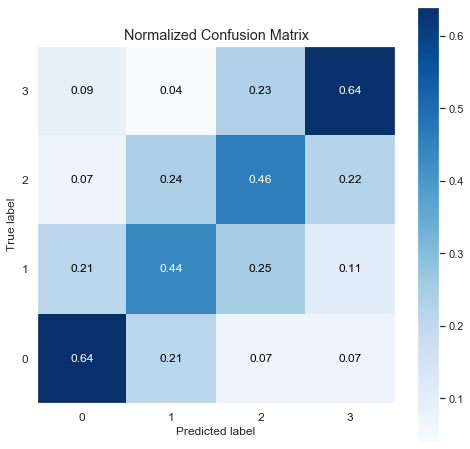

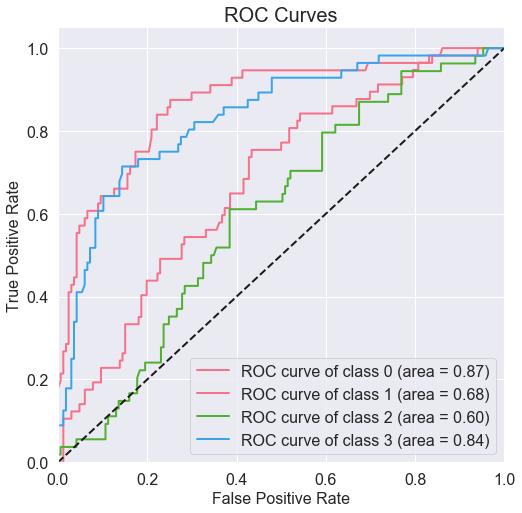

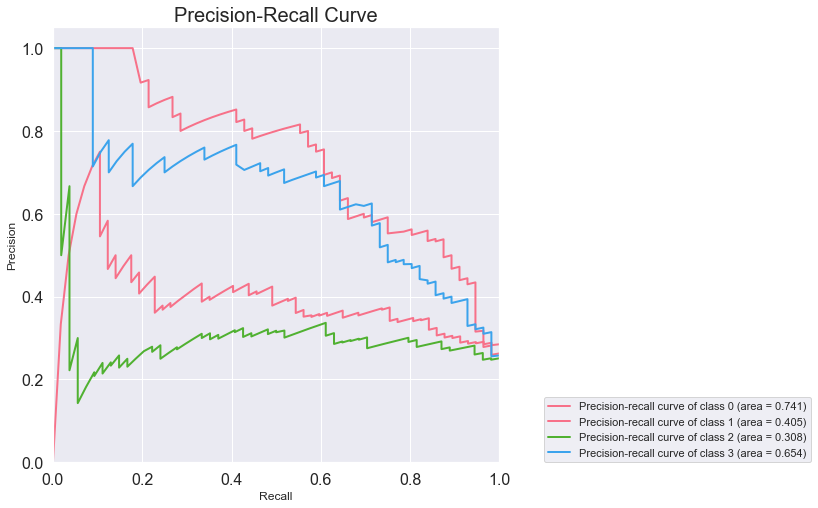

In [250]:
all_title_model.matrix_n_graphs()

In [89]:
# all_title_model.gridsearch()

In [90]:
# the best model from the above gridsearch
all_title_model.gridsearch({'C': [0.021544346900318846], 'class_weight': ['balanced'], 'l1_ratio': [0.2223], 'penalty': ['elasticnet'], 'solver': ['saga']})


Logistic Regression Model Grid Search:
Best Mean CV Model Score: 0.5235 - which is better than baseline by 0.2502 
Model Test Score: 0.4753 - better than baseline by 0.2021
Grid Best Parameters:
 {'C': 0.021544346900318846, 'class_weight': 'balanced', 'l1_ratio': 0.2223, 'penalty': 'elasticnet', 'solver': 'saga'}

Search Parameters:
 {'C': [0.021544346900318846], 'class_weight': ['balanced'], 'l1_ratio': [0.2223], 'penalty': ['elasticnet'], 'solver': ['saga']}


In [91]:
all_title_model.decision_tree_model()

Decision Tree Model Test
Model Score: 0.9341 - better than baseline by 0.6608 
CV Fold Score: 0.4909 - better than baseline by 0.2176 
Model Test Score: 0.5561 - better than baseline by 0.2828
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  0.11 secs - grid will take ~ 5.55 minutes to run.



In [92]:
all_title_model.gridsearch()

Decision Tree Model Grid Search:
Best Mean CV Model Score: 0.4956 - which is better than baseline by 0.2223 
Model Test Score: 0.4798 - better than baseline by 0.2065
Grid Best Parameters:
 {'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 5, 'splitter': 'best'}

Search Parameters:
 {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 6, 7, 8], 'max_features': ['auto'], 'splitter': ['best', 'random'], 'min_samples_split': [2, 3, 4, 5], 'ccp_alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': [None, 'balanced']}


In [93]:
all_title_model.knn_model(9)

K Neighbors Model Test
Model Score: 0.5687 - better than baseline by 0.2954 
CV Fold Score: 0.4686 - better than baseline by 0.1953 
Model Test Score: 0.4439 - better than baseline by 0.1707
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Set k='all' to run full set of ks and graph.
Time Elapsed =  0.67 secs - grid will take ~ 4.7 minutes to run - and all ks 5.86 mins



In [53]:
# going to try again with the count vectoriser fit from the title on the description field without refitting
des_words = cvec.transform(df_all.description)
deswords_df = pd.DataFrame(des_words.toarray(),columns=cvec.get_feature_names())

In [251]:
word_dic_des = {word: [deswords_df[word].sum()] for word in deswords_df}    

title_df_des = pd.DataFrame(word_dic_des).T.sort_values(0, ascending=False)

In [252]:
deswords_df.shape

(1482, 92)

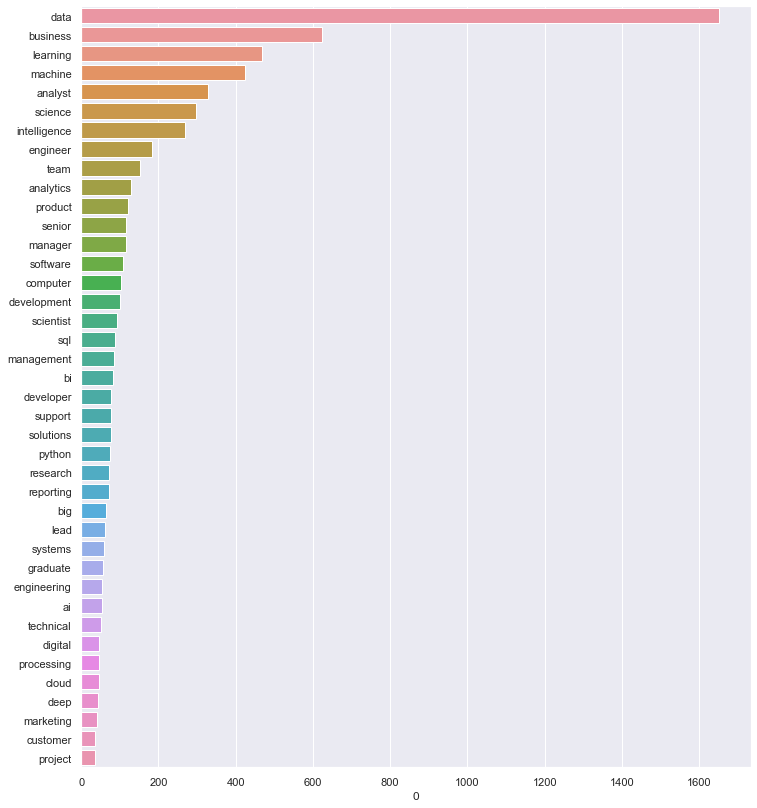

In [283]:
# same words so we get a similar graph
sns.set(rc={'figure.figsize':(12,14)})
sns.barplot(x=title_df_des[0][:40],y=title_df_des.index[:40]);

In [254]:
all_words = pd.concat([all_title,deswords_df],axis=1)

In [255]:
all_words_model = full_classification(all_words,y,baseline,standardize=True)

K Neighbors Model Test
Model Score: 0.633 - better than baseline by 0.3598 
CV Fold Score: 0.4512 - better than baseline by 0.1779 
Model Test Score: 0.4798 - better than baseline by 0.2065
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Set k='all' to run full set of ks and graph.
Time Elapsed =  1.05 secs - grid will take ~ 7.34 minutes to run - and all ks 9.15 mins

Decision Tree Model Test
Model Score: 0.996 - better than baseline by 0.7227 
CV Fold Score: 0.4821 - better than baseline by 0.2089 
Model Test Score: 0.4305 - better than baseline by 0.1572
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  0.13 secs - grid will take ~ 6.72 minutes to run.

Logistic Regression Model Test
Mo

In [54]:
all_words_model.decision_tree_model()


Decision Tree Model Test
Model Score: 0.996 - better than baseline by 0.7227 
CV Fold Score: 0.4718 - better than baseline by 0.1985 
Model Test Score: 0.4753 - better than baseline by 0.2021
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  0.25 secs - grid will take ~ 12.57 minutes to run.



In [55]:

# all_words_model.gridsearch()

Decision Tree Model Grid Search:
Best Mean CV Model Score: 0.4647 - which is better than baseline by 0.1914 
Model Test Score: 0.4619 - better than baseline by 0.1886
Grid Best Parameters:
 {'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 3, 'splitter': 'random'}

Search Parameters:
 {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 6, 7, 8], 'max_features': ['auto'], 'splitter': ['best', 'random'], 'min_samples_split': [2, 3, 4, 5], 'ccp_alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'class_weight': [None, 'balanced']}


In [139]:
all_words_model.knn_model(1)

K Neighbors Model Test
Model Score: 0.9984 - better than baseline by 0.7251 
CV Fold Score: 0.4321 - better than baseline by 0.1588 
Model Test Score: 0.4888 - better than baseline by 0.2155
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Set k='all' to run full set of ks and graph.
Time Elapsed =  0.77 secs - grid will take ~ 5.41 minutes to run - and all ks 13.5 mins



This doesn't improve the model - actually seems to crowd it and make it worse, perhaps getting too many of the words in the description which confuses the model slightly (though there is not much in it). I am going to try and refit the words based on the description to see if the descriptions themselves have valuable information in them above and beyond the job titles.

In [257]:
cvec2 = CountVectorizer(stop_words="english", ngram_range=(1,2),min_df=0.005)

# making sure I only fit on the training data - splitting the same way as rest of model
des_train, des_test, des_y, des_y_test = train_test_split(df_all['description'], y, test_size=0.15, random_state=66)
cvec2.fit(des_train)
# fitting all descriptions
des_words2 = cvec2.transform(df_all.description)
deswords_df2 = pd.DataFrame(des_words2.toarray(),columns=cvec2.get_feature_names())

In [258]:
deswords_df2

,000,50,ability,accurate,accurately,accurately using,actionable,advanced,agency,agency employment,...,working,working closely,working data,world,year,year preferred,year professional,years,years experience,équipe
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1479,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [259]:
word_dic_des2 = {word: [deswords_df2[word].sum()] for word in deswords_df2}    

title_df_des2 = pd.DataFrame(word_dic_des2).T.sort_values(0, ascending=False)

In [260]:
# the minimum amount of times a word can show up is 7 in order to be included
title_df_des2

,0
data,1651
business,624
learning,467
machine,423
machine learning,403
...,...
learning artificial,7
share,7
focused,7
focussed,7


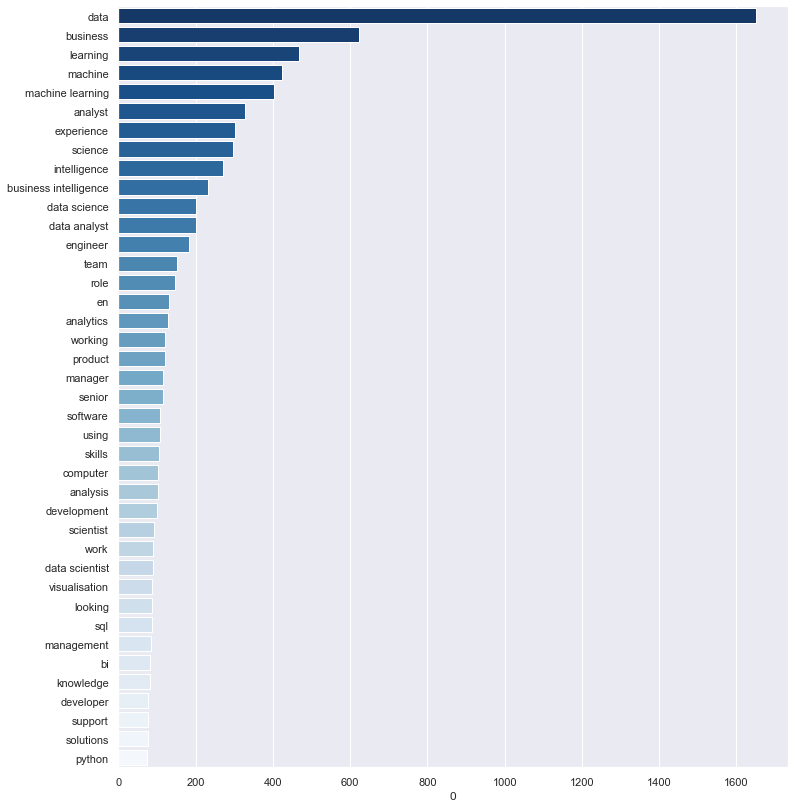

In [332]:
sns.set(rc={'figure.figsize':(12,14)})
sns.barplot(x=title_df_des2[0][:40],y=title_df_des2.index[:40],palette="Blues_r");

In [263]:
all_words2 = pd.concat([all_title,deswords_df2],axis=1)

In [264]:


all_words_model2 = full_classification(all_words2,y,baseline,standardize=True)

K Neighbors Model Test
Model Score: 0.6728 - better than baseline by 0.3995 
CV Fold Score: 0.3741 - better than baseline by 0.1009 
Model Test Score: 0.3857 - better than baseline by 0.1124
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Set k='all' to run full set of ks and graph.
Time Elapsed =  3.89 secs - grid will take ~ 27.23 minutes to run - and all ks 33.98 mins

Decision Tree Model Test
Model Score: 0.9984 - better than baseline by 0.7251 
CV Fold Score: 0.4781 - better than baseline by 0.2049 
Model Test Score: 0.4753 - better than baseline by 0.2021
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  0.48 secs - grid will take ~ 23.8 minutes to run.

Logistic Regression Model Tes

In [85]:
# all_words_model2.gridsearch()

# best logiststic gridsearch
# Grid Best Parameters:
#  {'C': 0.2782559402207126, 'class_weight': 'balanced', 'l1_ratio': 0.5556, 'penalty': 'elasticnet', 'solver': 'saga'}


In [265]:
# best logistic model for this based on very long grid search above
all_words_model2.logistic_model(LogisticRegression(C= 0.2782559402207126, class_weight= 'balanced', l1_ratio= 0.5556, penalty= 'elasticnet', solver= 'saga'))
best_model = all_words_model2.model

Logistic Regression Model Test
Model Score: 0.9778 - better than baseline by 0.7045 
CV Fold Score: 0.4917 - better than baseline by 0.2184 
Model Test Score: 0.4888 - better than baseline by 0.2155
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Run .coefs() to see coef dataframe
Time Elapsed =  18.77 secs - grid will take ~ 563.24 minutes to run.



In [266]:
alldone()

Boosting Model Test
Model Score: 0.664 - better than baseline by 0.3907 
CV Fold Score: 0.5123 - better than baseline by 0.239 
Model Test Score: 0.4798 - better than baseline by 0.2065
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  8.46 secs - grid will take ~ 21.14 minutes to run.



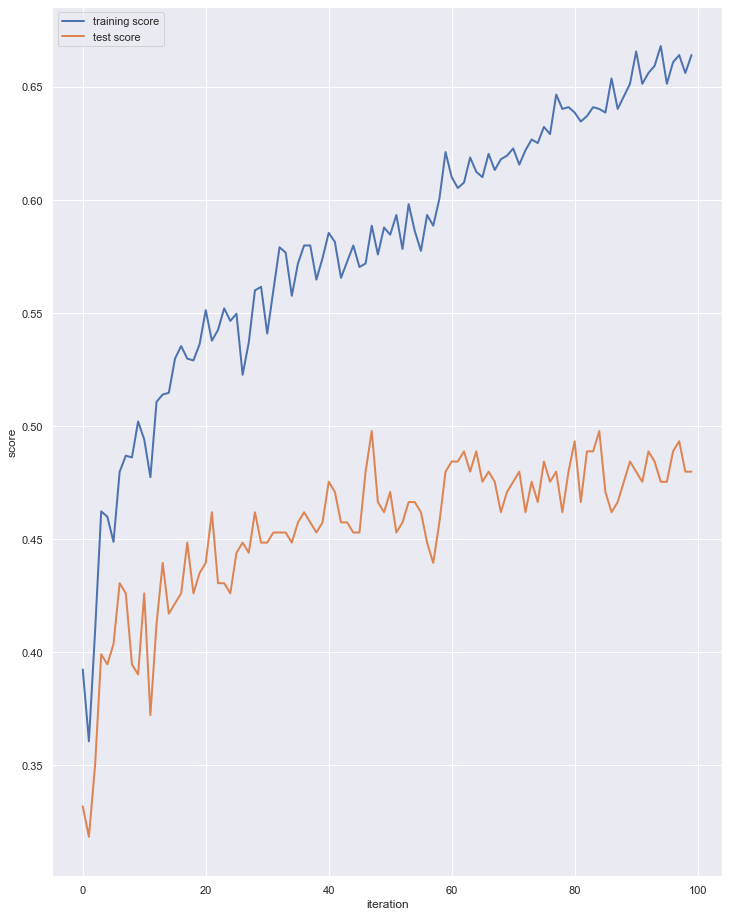

In [267]:
# Boosting 

all_words_model2.boosting_model(estimators=100)

In [268]:
# all_words_model2.gridsearch()

# Best Mean CV Model Score: 0.5266 - which is better than baseline by 0.2534 
# Model Test Score: 0.5112 - better than baseline by 0.2379

# Grid Best Parameters:
#  {'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
#                        max_depth=5, max_features=None, max_leaf_nodes=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=1, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, presort='deprecated',
#                        random_state=None, splitter='best'), 'learning_rate': 0.75, 'n_estimators': 200}


In [276]:
# Random Forest
all_words_model2.random_forest_model(RandomForestClassifier(random_state=66))


Random Forest Model Test
Model Score: 0.9984 - better than baseline by 0.7251 
CV Fold Score: 0.556 - better than baseline by 0.2827 
Model Test Score: 0.4978 - better than baseline by 0.2245
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  3.52 secs - grid will take ~ 33.44 minutes to run.



In [277]:
# all_words_model2.gridsearch()
# Grid Best Parameters:
#  {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 500, 'oob_score': True, 'warm_start': True}

# Search Parameters:
#  {'n_estimators': [100, 200, 500], 'criterion': ['gini', 'entropy'], 'max_depth': [None], 'min_samples_split': [2, 6], 'max_features': ['auto', 'log2'], 'oob_score': [True, False], 'warm_start': [True, False], 'ccp_alpha': [0.0, 0.5, 1]}

Fitting 6 folds for each of 288 candidates, totalling 1728 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1728 out of 1728 | elapsed: 34.2min finished


Random Forest Model Grid Search:
Best Mean CV Model Score: 0.5655 - which is better than baseline by 0.2923 
Model Test Score: 0.5291 - better than baseline by 0.2559
Grid Best Parameters:
 {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 500, 'oob_score': True, 'warm_start': True}

Search Parameters:
 {'n_estimators': [100, 200, 500], 'criterion': ['gini', 'entropy'], 'max_depth': [None], 'min_samples_split': [2, 6], 'max_features': ['auto', 'log2'], 'oob_score': [True, False], 'warm_start': [True, False], 'ccp_alpha': [0.0, 0.5, 1]}


In [280]:
# best model from the gridsearch
best_model_features = RandomForestClassifier(max_features='auto',criterion='entropy',n_estimators=500,oob_score = True, warm_start=True, random_state=66)
all_words_model2.random_forest_model(best_model_features)


Random Forest Model Test
Model Score: 0.9984 - better than baseline by 0.7251 
CV Fold Score: 0.5655 - better than baseline by 0.2923 
Model Test Score: 0.5291 - better than baseline by 0.2559
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  22.39 secs - grid will take ~ 212.66 minutes to run.



In [281]:
alldone()

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

##### Looking to answer both of these questions together below:

Random Forest Model on X_test


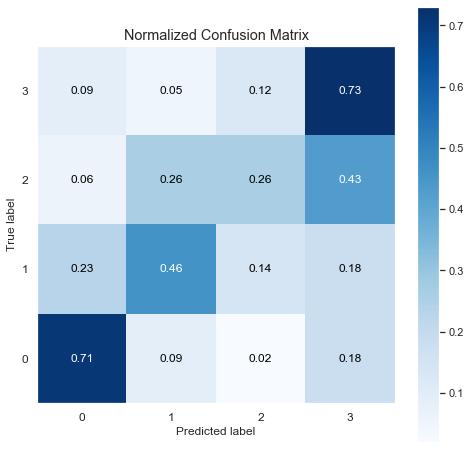

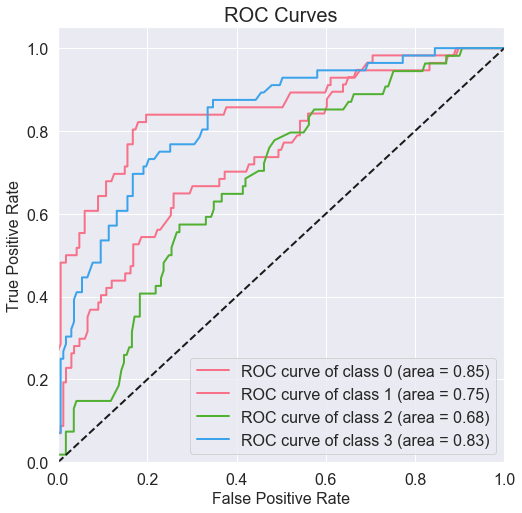

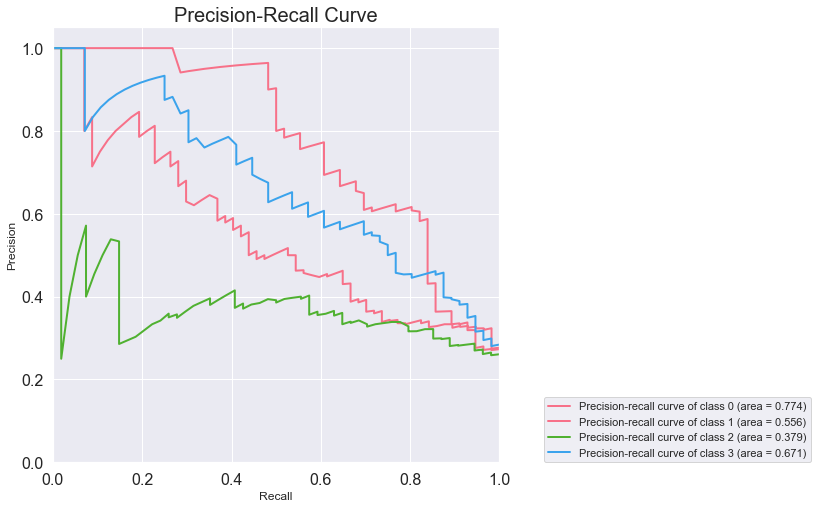

In [161]:
all_words_model2.matrix_n_graphs()

### ROC/precision-recall curves

From the first model (including only location) to the final one (including location, rating, count vectoriser on title and seperate count vectoriser on description) the main pattern we can see from the ROC and Precision-Recall curves is the overall improvement of the model. The AUC in the initial model for both graphs is very poor across all classes. The only class which has a half decent AUC is class 3 in the initial ROC graph. As the model increases in complexity and the accuracy increases, you can see both the ROC and P-R curves becoming more solid. Both class 0 and class 3 are pretty well predicted, with an AUC in the ROC curve of about 85%. the model is much better at predicting the extremes than the middle two categories. 

Although it certainly increases as the model improves, the Recall and Precision is not very high for any of the classes, however we observe the same pattern of the extreme classes (0 and 3) having the best precision and recall and increase thereof. Class 2 still has an extremly low precision, with the area under the precision recall curve only increasing by about 5% with the best model. This indicates that class two will still have a relatively high false positive rate (low precision) and also a high false negative rate (low recall).

Class 0


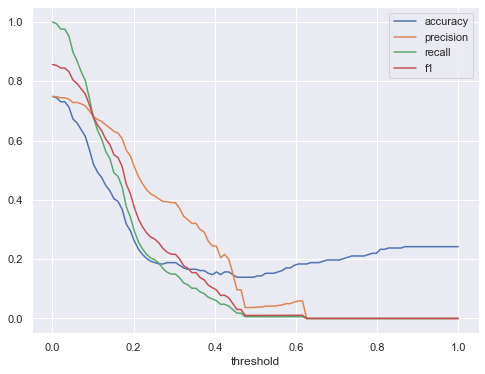

Class 1


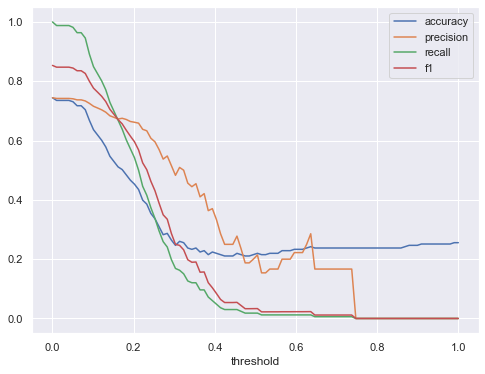

Class 2


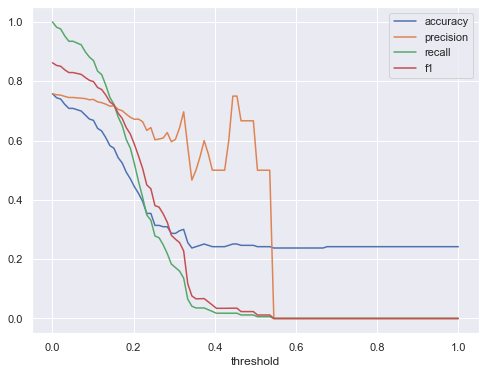

Class 3


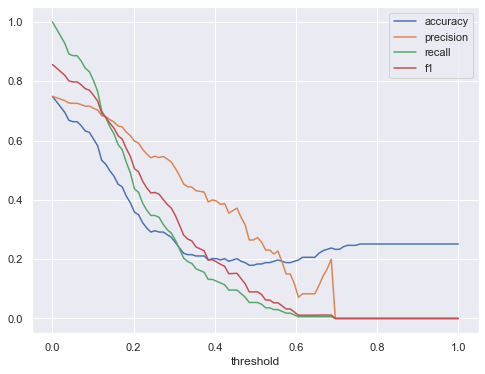

In [162]:
# Evaluation the accuracy, precision, recall and F1 score for each class versus all other classes 

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


probs = pd.DataFrame(all_words_model2.model.predict_proba(all_words_model2.X_test))
for col in probs:
    print("Class", col)
    predictions = [probs[col].apply(lambda x: 1 if x>= i else 0) for i in np.linspace(0, 1, 100)]
    y_test_1vall = [1 if num!=col else 0 for num in all_words_model2.y_test]
    scores = np.array([(threshold, accuracy_score(y_test_1vall, predictions[i]),
                        precision_score(y_test_1vall, predictions[i]),
                        recall_score(y_test_1vall, predictions[i]),
                        f1_score(y_test_1vall, predictions[i])) 
                       for i, threshold in enumerate(np.linspace(0, 1, 100))])
    plt.figure(figsize=(8, 6))
    plt.plot(scores[:, 0], scores[:, 1], label='accuracy')
    plt.plot(scores[:, 0], scores[:, 2], label='precision')
    plt.plot(scores[:, 0], scores[:, 3], label='recall')
    plt.plot(scores[:, 0], scores[:, 4], label='f1')
    plt.legend()
    plt.xlabel('threshold')
    plt.show()



### Predicting lower salaries more often: 

Above I am mapping out the accuracy, precision, recall and F1 score for each class versus all other classes based on the threshold level for selecting that class. Here you can see that the graph is roughly the same for all classes. If you want to select any one particular class more often, the best solution would be to reduce the threshold for that class (versus all others) to very close to zero. The issue for all of the them is that in order to get the recall close to 1 (always correctly predicting that class when it should be that class), then the threshold would have to be very close to zero. This means that you would basically only be predicting this class, and so you be very close to baseline again  - or even if you want to be predicting class 0 more often, you may even be below baseline as 0 class has a lower weight than baseline. 

Further to this, it is also an issue because you are not really working on reducing higher salaries generally, but you are merely shifting more predictions into one class. If this model was set up as a binary class outcome (just high or low) then we would be able to use threshold more easily to shift predictions into the lower salary class. Since we have four categories however, the threshold is not the most efficient tool to use to predict lower salaries more often. 

For example, if a salary which should have been class 1 or 2 is incorrectly classified as class 3, then you would prefer to force it to predict 1 or 2 more often, but you wouldnt be able to do this by lowering the threshold for class 0. If you lower the threshold for class 0, you would be jumping the predictions from class 3 to class 0, without giving them the opportunity to reclassify into one of the middle classes. 

Therefore I am going to look at a more effective method below of weighting the classes below so that the higher classes are penalised in an more equal way, hopefully making the overall model more accurate.

In [163]:

# best model from the gridsearch with a large shift in class weight in order to demonstrate the effect of penalising the higher salaries
all_words_model2.random_forest_model(RandomForestClassifier(class_weight={0:10000000,1:10000000,2:.1,3:.001},max_features='log2',n_estimators=500,oob_score = True, warm_start=True, random_state=66))

Random Forest Model Test
Model Score: 0.4972 - better than baseline by 0.2239 
CV Fold Score: 0.3606 - better than baseline by 0.0873 
Model Test Score: 0.3767 - better than baseline by 0.1034
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  17.55 secs - grid will take ~ 166.68 minutes to run.



Random Forest Model on X_test


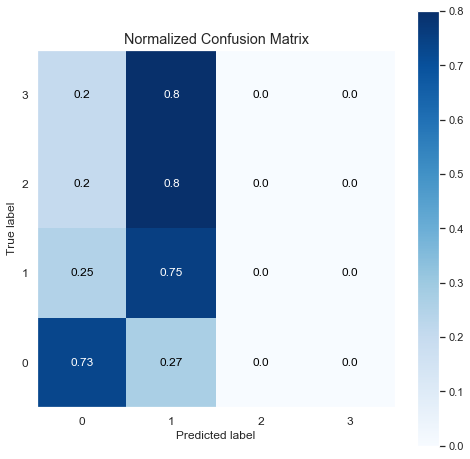

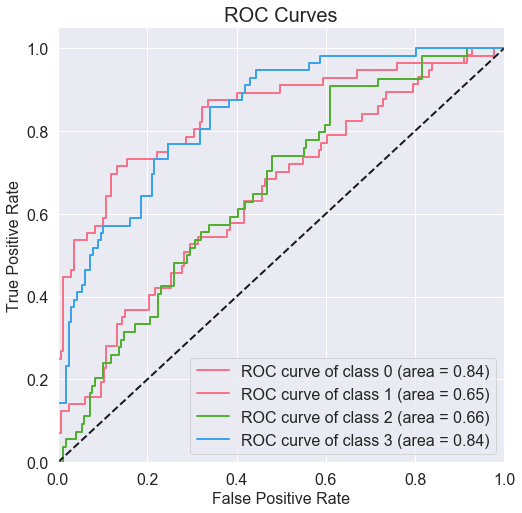

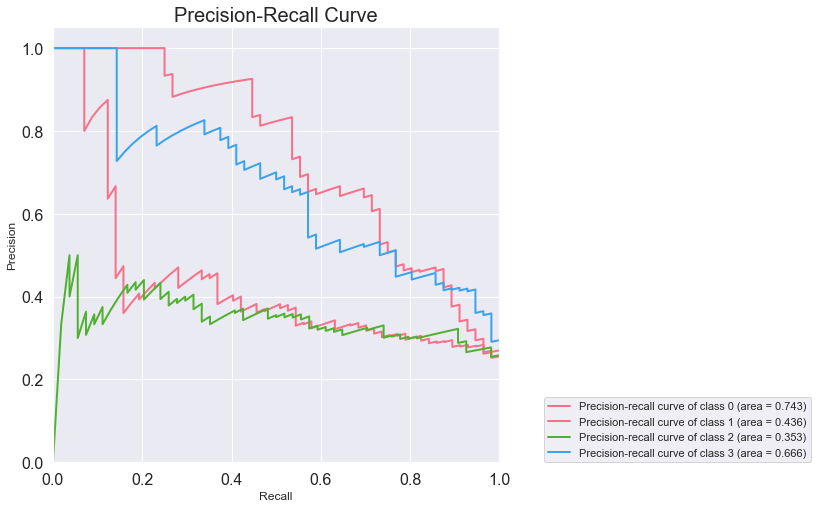

In [164]:
all_words_model2.matrix_n_graphs()

## Shifting the class weights for reclassification

Increasing the weight of the lower classes is the best way of adjusting the random forest model for multi class classification. As you can see in an extreme weight change example above, we are never predicting class 2 and 3 anymore (high and very high salary). In the confusion matrix above, the predcitions from 2 and 3 are forced into class 1 (the medium salary bracket). While this shift does mean you are no longer predicting the top two classes, this also comes at the cost of accuracy, the model accuracy has dropped by ~0.2, which is a very large drop for this model! As you force more predictions into the lower classes, they are more likely to be predicting incorrectly this way. 

In order to help the boss decide where to place the weights I will check the False Positive rates versus overall CV accuracy score over different class weights so the model can be tailored and the tradeoff can be visualised. 

In [165]:
all_words_model2.random_forest_model(best_model_features)

/Users/lukebetham/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Random Forest Model Test
Model Score: 0.9984 - better than baseline by 0.7251 
CV Fold Score: 0.5632 - better than baseline by 0.2899 
Model Test Score: 0.5426 - better than baseline by 0.2693
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  17.71 secs - grid will take ~ 168.28 minutes to run.



In [166]:
# finding all of the metric over a number of random forest models to reduce false positives for higher salaries
# only going to use accuracy and false positive to start (as we are trying to reduce false positives in higher salaries)
# I am going to be penalising category 2 and 3, and penalising 3 twice as much as 2. 
import sys
import os

#suppress the printing during the loop
oldstd = sys.stdout
sys.stdout = open(os.devnull, "w")
cvs_scores = []
FPs = []
FPRs = []
ACCs = []

for x in np.logspace(4,8,100):
    weighting_dict = {0:1,1:1,2:1/x,3:1/x}
    all_words_model2.random_forest_model(RandomForestClassifier(class_weight=weighting_dict,random_state=66))
    cvs_scores.append(all_words_model2.cvs)
    cnf_matrix = confusion_matrix(all_words_model2.y_test, all_words_model2.model.predict(all_words_model2.X_test))
    
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    FPs.append(list(FP))
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    FPRs.append(list(FPR))
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    ACCs.append(list(ACC))
    
    
sys.stdout = oldstd


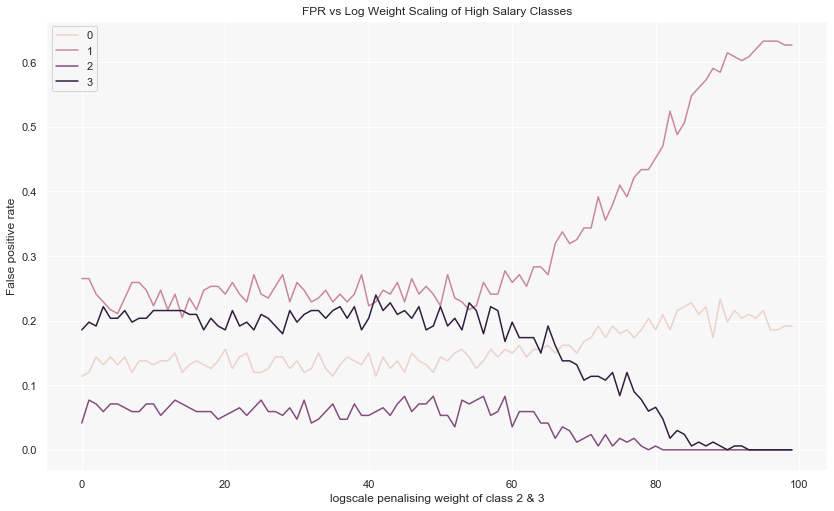

In [167]:
# False positive rate for each class versus logscale penalisation of class 2 and 3 (higher salaries)

sns.set(rc={'figure.figsize':(14,8.27)})
sns.set_style("darkgrid", {"axes.facecolor": "0.97"})

ax = sns.lineplot(data=pd.DataFrame(FPRs),dashes=False,palette=sns.cubehelix_palette(4,start=3));
ax.set(xlabel='logscale penalising weight of class 2 & 3', ylabel='False positive rate',title="FPR vs Log Weight Scaling of High Salary Classes")
plt.show()



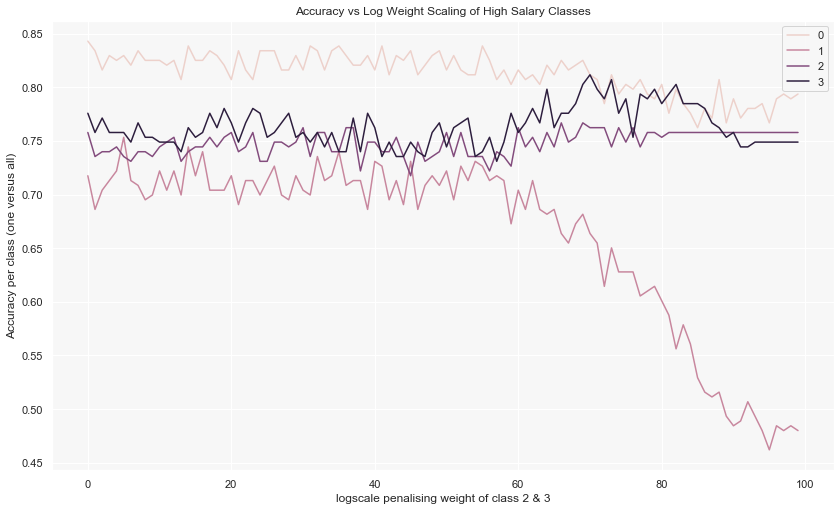

In [168]:
# accuracies per class versus logscale penalisation of class 2 and 3 (higher salaries)

ax = sns.lineplot(data=pd.DataFrame(ACCs),dashes=False,palette=sns.cubehelix_palette(4,start=3));
ax.set(xlabel='logscale penalising weight of class 2 & 3', ylabel='Accuracy per class (one versus all)',title="Accuracy vs Log Weight Scaling of High Salary Classes")
plt.show()

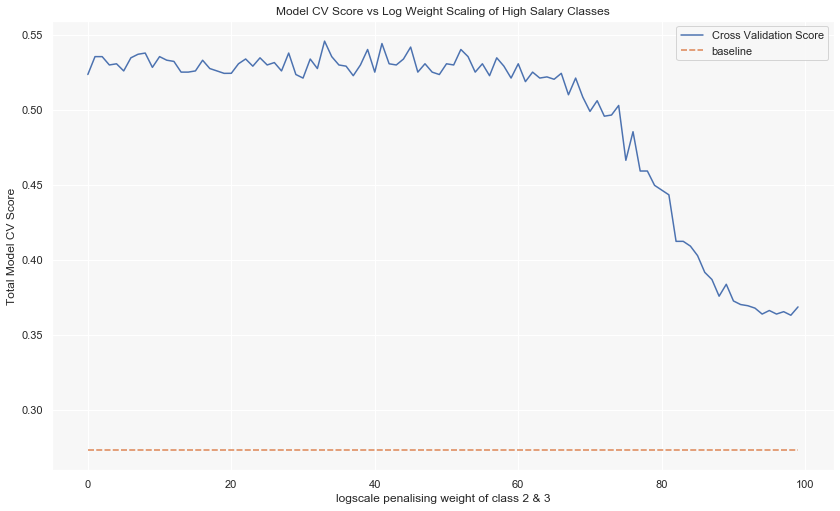

In [169]:
# total model CV score and baseline versus logscale penalisation of class 2 and 3 (higher salaries)
cvs_df = pd.DataFrame(cvs_scores,columns=["Cross Validation Score"])
cvs_df["baseline"] = baseline
# sns.lineplot(data=pd.DataFrame(FPRs), dashes=False, color="g")
# ax2 = plt.twinx()
ax = sns.lineplot(data=cvs_df);
ax.set(xlabel='logscale penalising weight of class 2 & 3', ylabel='Total Model CV Score',title="Model CV Score vs Log Weight Scaling of High Salary Classes")
plt.show()

### Shifting class weights loop

As can be seen above - I have penalised class 2 and 3 on a logscale starting at 10^4 and ending at 10^8, with 100 points between these two figures (this range was chosen based on a few iterations). The first graph shows that as you increase the weight penalty on the top two classes, the false positive rate decreases, meaning that there are less jobs being predicted incorrectly as high or very high salaries. As previously mentioned, these predictions are moved into the next highest category, category one, which is why you can see such a large increase in the false positive rate for class 1, while class 0 (low salaries stays relatively unchanged. The good thing with this approach is that you can decide where you would most like to predict and falsely predict. 

As predicted, this class weight change comes at the cost of overall accuracy. The last graph shows how the overall CV score of the model reduces as you increase the penalty (closely following in line with the reduction in false positive rate for the top two classes). Using these graphs, you can try and find a sweet spot where you have reduced the overprediction of the top two classes without having dropped your overall accuracy by too much. For instance, we could decide to select the model on the 80th number in the logspace range, as this seems to have a decent balance. I will now re-run the model with this penalty to show the impact on the model and its confusion matrix.

In [170]:
penalty = np.logspace(4,8,100)[80]

In [171]:
# best model with an effective penalty from the above graphs
all_words_model2.random_forest_model(RandomForestClassifier(class_weight={0:1,1:1,2:1/penalty,3:1/penalty},max_features='log2',n_estimators=500,oob_score = True, warm_start=True, random_state=66))

Random Forest Model Test
Model Score: 0.9921 - better than baseline by 0.7188 
CV Fold Score: 0.5036 - better than baseline by 0.2303 
Model Test Score: 0.4798 - better than baseline by 0.2065
Use .gridsearch() to run full regularisation tests using all default for current model. 
Use .knn_model() or .logistic_model() or .decision_tree_model() to change model and specify paramters.
Time Elapsed =  17.02 secs - grid will take ~ 161.66 minutes to run.



Random Forest Model on X_test


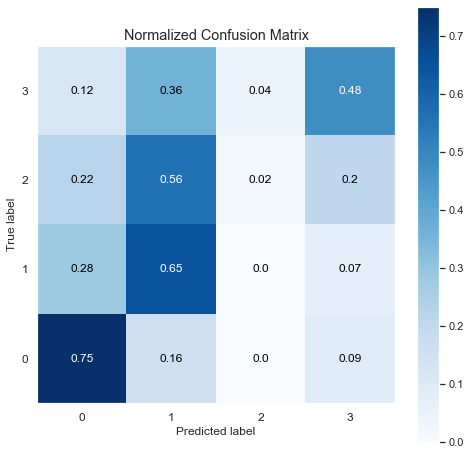

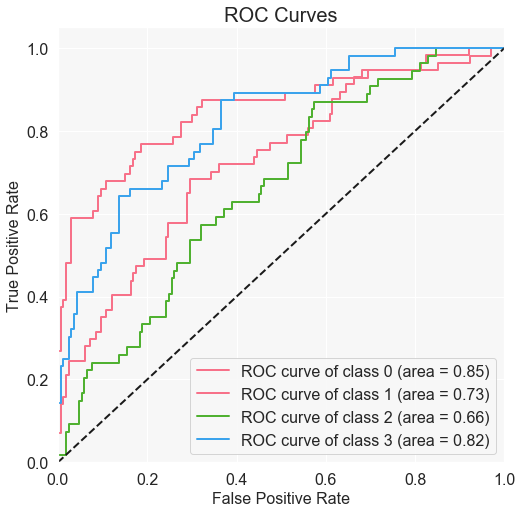

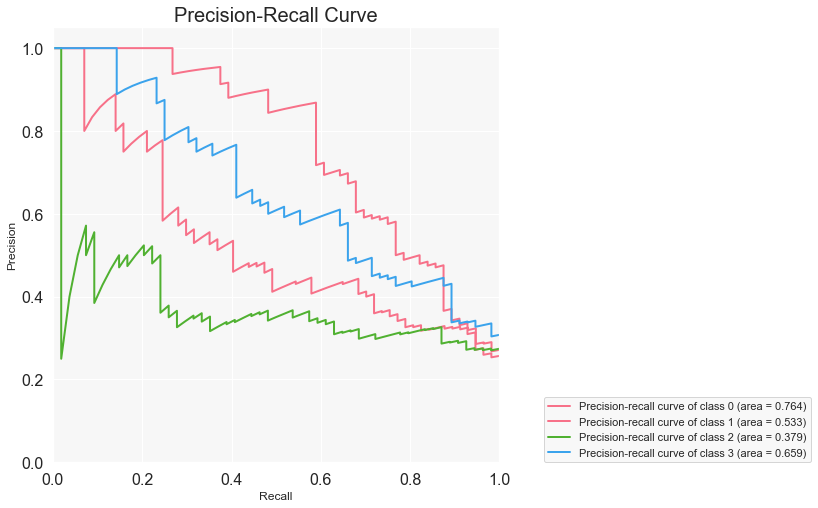

In [172]:
all_words_model2.matrix_n_graphs()

In [173]:
alldone()

You can see a strong improvement in the model with regards to under-estimating rather than overestimating salary. This is visualised in the matrix as the area under the diagonal versus the area above the diagonal. While there has been a small drop in the overall CV score of the model, the model is now much more likely to under-predict. However, you can see that the model is still able to predict the highest salary band correctly 50% of the time. The one major casualty in this model has been class 2, which is now only being predicted correctly 2% of the time (from 25% previously) this could be down to the fact that the model was better at estimating the class 3 than it was class 2 before, and so the penalty should not be applied to both classes in the same way. In fact, you could add further complexity here and apply the penalty differently for all classes, increasing the penatly for higher classes in order to improve the model further. This would probably reduce the overestimation of class 2 as class 3s and class 0s as class 1s, which is still happening notably.

A new scaling penalty could look like {0:10*x,1:x,2:1/x,3:1/(10*x)} where x is a similar logscale space. 

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

## Executive Summary

#### The data
This study provides an analysis of available salaries related to the data science field on various indeed.com websites across Europe. The analysis is using data scraped from the website for a number of UK and European cities on 20/01/2020. The aim was to create a usable model which would be able to predict whether a job would have a high or low salary based on the information available on the summary card on the website. 

I was searching only for certain types of jobs related to data science, and so the keywords being searched for were: "data scientist" or "data engineer" or "business intelligence" or "data product manager" or "data analyst" or "data science" or "machine learning" or "data architect" or "data visualisation".

I was able to collect 1,482 data points with the split per city looking like this:
 - London                 231
 - Manchester             145
 - Dublin                  97
 - Oxford                  96
 - Birmingham              92
 - Cambridge               87
 - Leeds                   76
 - Bristol                 75
 - Paris                   75
 - Southampton             60
 - Edinburgh               47
 - Madrid                  39
 - Slough                  36
 - Liverpool               36
 - Amsterdam               35
 - Newcastle-upon-Tyne     35
 - Nottingham              34
 - Barcelona               27
 - Cardiff                 27
 - Leicester               25
 - Belfast                 24
 - Glasgow                 23
 - Frankfurt               22
 - Sheffield               19
 - Berlin                  18
 - Lisbon                   1

It should be noted that almost 2/3 of the data is from the UK; I was being selective on which European cities to look at as I was only considering cities where I would be interested in living in the near future.  

#### The model
I decided to try and predict salary bands based on the quartiles of the data, which meant splitting them into the below categories:

 - Low (0) = less than £32.5k
 - Medium (1) = between £32.5k and £41k
 - High (2) = between £41k and £55k
 - Very High (3) = above £55k

Using this data I created a number of models with increasing complexity to try and predict the salary level. The features I looked to include from the data was:
1.	The city the job was located in*
2.	The rating of the company posting the job*
3.	Specific keywords in the job title: intern, manager, lead, analyst, senior, engineer, architect, head, assistant, junior, scientist, machine learning, grad, intelligence, product, business, support, associate.
4.	A count of the words in the job-titles which were in more than 0.5% of titles (has to be in more than 7 of the jobs)*
5.	A term frequency of words in the jobtitles (similar to 4, but a way of assigning importance to a word). 
6.	A count of the same words from 4 but this time counting how often they appear in the description rather than job title. 
7.	A count of the words and 2 word combinations  in the descriptions which appear in more than 0.5% of descriptions.*

*The final and best model which I created was based on all of the above features which are starred. 

I didn’t look to include any information about the date that the job was posted, as this was categorised into small bands, with the majority of jobs being in the 30 days+ band, so I did not think this would be of any use. 
 
Each category accounts for about 25% of the data, and the final and best model described above was able to predict the salary correctly 56% of the time. This is far from a perfect model, however it is predicting based on limited information using quite sporadic and ranging data, so this is to be expected somewhat. The model was the best at predicting when salaries where going to be Low (less than 32.5k) or Very High (above 55k) and struggled more with the middle classes, making many more incorrect predicitons here. 

The specific models checked for this analysis were: Logistic Regression, decision tree classification, K nearest neighbours classification, random forest model and boosting model based on decision trees. The final and best model was a Random Forest model. 

The model was not incredibly accurate, however it does have some predictive power, and could be used for rough estimates. 

#### Adjusting the final model
In the end of the analysis, I re-adjusted the model in order to force it to underestimate salary more often than it would over-estimate. This means making the model predict Low and Medium salaries more often than High and Very High. This is based on the belief that it is better to be told that you are going to get a lower salary than reality than the other way round, in order to avoid disappointment! Adjusting the model in this way does make it less accurate, and my report graphs the decrease in accuracy versus this shift in incorrect predictions so that the user can make an informed decision on how much to adjust the model by. Intuitively, penalising the higher salaries meant that the model predicted the medium salary the most often, and this category ends up having the most false positives, while the predictions for lower salaries remained relatively unchanged.

#### Recommendations on more work to be done to improve this analysis and model:
-	Increase the amount of data – this could be done by looking at more cities and countries on indeed.com, or by scraping the website a few more times at regular intervals to get new jobs, or look at a few more websites to see if we can get more salaries or even more data fields to try and include in the model.
-	More in-depth scraping where you click into each job and get the full job description rather than just the summary blurb on the title page could yield better results. Would have a lot more predictors.
-	Further work could be done to find a better weighting for penalising higher salaries so that the effect is more balanced across the classes.
-	Work could be done to estimate whether jobs which are posted with hourly, weekly or monthly salaries are worth including in the dataset.

#### Limitations:
-	The data here is only as good as the people posting it, it might not be the best – 
    
    - In order to get these 1,500 salaries, we needed to scrape though about 20,000 jobs, and remove thousands of duplicates and jobs where there were no salaries.
    - Some cities had very few data points as you can see above – its possible that culturally some countries are less likely to post salaries than others, and that the ones that do post are much above or below the average.
     - The date field doesn’t show how old the listings are so its impossible to know how current they are or if they are all even still relevant. 
     - Many of the salary fields had a wide range (e.g. 25k-35k) and so we took the average of this range, which may not be the best methodology.
-	A classification model trying to classify into four categories here might not be the best type of model to employ, it would be better to build a model around a regression, where you can predict the exact salary figure. 












<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

https://elastikeyvignite.code.blog/2020/01/27/predicting-data-salaries-with-classification-nlp/
